In [10]:
import sys
import os

In [11]:

root_list = ["/data_preprocessing/", "/TARN_MAPPO"]
for root in root_list:
    sys.path.append(os.getcwd() + root)
sys.path.append(os.getcwd())

In [12]:
sys.path

['/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/workspace/base_line_model/Task_1_FinRL_DeepSeek_Stock/data_preprocessing/',
 '/workspace/base_line_model/Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO',
 '/workspace/base_line_model/Task_1_FinRL_DeepSeek_Stock',
 '/workspace/base_line_model/Task_1_FinRL_DeepSeek_Stock',
 '/workspace/base_line_model/Task_1_FinRL_DeepSeek_Stock',
 '/workspace/base_line_model/Task_1_FinRL_DeepSeek_Stock',
 '/tmp/tmpxfobcr80',
 '/workspace/base_line_model/Task_1_FinRL_DeepSeek_Stock',
 '/workspace/base_line_model/Task_1_FinRL_DeepSeek_Stock/data_preprocessing/',
 '/workspace/base_line_model/Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO',
 '/workspace/base_line_model/Task_1_FinRL_DeepSeek_Stock']

In [13]:
%load_ext autoreload
%autoreload 2
# root_list = ["/data_preprocessing", "/TARN_PPO"]
# for root in root_list:
#     sys.path.append(os.getcwd() + root)
# sys.path.append('/workspace')
# os.chdir('/workspace')
import pandas as pd
import numpy as np
# from data_preprocessing.preprocessing_config import *
# from preprocessing_config import *
# from utils import *
# root_list = ["/data_preprocessing", "/TARN_MAPPO"]
# for root in root_list:
#     sys.path.append(os.getcwd() + root)
# sys.path.append('/workspace')
# os.chdir('/workspace')
import dynamic_portfolio as dp
import data_preprocessing.technical_indicators as ti
import data_preprocessing.main_preprocessing as preprop
from TARN_MAPPO.run import *
from TARN_PPO.agent import PPO
import copy
from TARN_PPO.enviroment import EnvConfig, Stock_Env
import TARN_PPO.backtesting as backtest
# import wandb
import pickle
import random
import copy

import torch
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 벤치마크 데이터


- 각 포트폴리오 수익률
- S&P 500 수익률

In [14]:
test_scaled_data_path = "./data/test_daily_v4.pkl"
test_dataset_path = "data/test_v4.csv"
test_scaled_tensor_path = "data/test_daily_data_v4.pt"

with open(test_scaled_data_path, "rb") as f:
    test_data = pickle.load(f)
    
test_dataset = pd.read_csv(test_dataset_path, index_col=0)
test_dataset.set_index("date", inplace=True)


test_scaled_tensor = torch.load(test_scaled_tensor_path)
test_scaled_tensor = test_scaled_tensor

feature_dim = 15


In [15]:
def get_hyperparameters(feature_dim):
    return {
        "dcc_dropout": 0.2,
        "sac_dropout": 0.01,
        "sac_heads": 2,
        "ddc_configs": [
            {"in_channels": feature_dim, "out_channels": 8, "kernel_size": 3, "stride": 1, "padding": (3-1)//2, "dilation": 1, "sac_scale": 4**0.5, "residual_out_channels" : 8, "residual_kernal": 1},
            {"in_channels": 8, "out_channels": 16, "kernel_size": 3, "stride": 1, "padding": 2, "dilation": 2, "sac_scale": 8**0.5, "residual_out_channels" : 16, "residual_kernal": 1 },
            {"in_channels": 16, "out_channels": 16, "kernel_size": 3, "stride": 1, "padding": 4, "dilation": 4, "sac_scale": 8**0.5}
        ],
        "final_conv_config": {"in_channels" : 16, "out_channels": 8, "kernel_size": 20, "stride": 1, "padding": 0}
    }
hyperparameters = get_hyperparameters(feature_dim)

In [16]:



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Utility Functions
def calculate_metric(returns_strategy, returns_benchmark, confidence_level=0.05, upside_confidence=0.95):
    """Calculate performance metrics: IR, CVaR, and Rachev Ratio."""
    excess_return = returns_strategy - returns_benchmark
    ir = excess_return.mean() / excess_return.std()
    var = np.percentile(returns_strategy, confidence_level * 100)
    cvar = returns_strategy[returns_strategy <= var].mean()
    upside_var = np.percentile(returns_strategy, upside_confidence * 100)
    downside_var = var
    rachev_ratio = returns_strategy[returns_strategy >= upside_var].mean() / abs(returns_strategy[returns_strategy <= downside_var].mean())
    return {"Information Ratio": ir, "CVaR": cvar, "Rachev Ratio": rachev_ratio}

def align_returns(result, col_strategy, col_benchmark):
    """Align returns for strategy and benchmark."""
    returns_strategy = result[col_strategy].pct_change().dropna()
    returns_benchmark = result[col_benchmark].pct_change().dropna()
    return returns_strategy.align(returns_benchmark, join="inner")

# Metrics Calculation
def compute_metrics(result, strategies, benchmark, confidence_level=0.05, upside_confidence=0.95):
    """
    Compute metrics for multiple strategies compared to a benchmark.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark columns.
        strategies (list): List of strategy column names.
        benchmark (str): Benchmark column name.
        confidence_level (float): Confidence level for CVaR calculation.
        upside_confidence (float): Confidence level for upside in Rachev Ratio.

    Returns:
        dict: Performance metrics for each strategy.
    """
    metrics = {}
    for strategy in strategies:
        aligned_strategy, aligned_benchmark = align_returns(result, strategy, benchmark)
        metrics[strategy] = calculate_metric(
            aligned_strategy, aligned_benchmark, confidence_level, upside_confidence
        )
    return metrics

# Plotting
def plot_cumulative_returns(result, metrics, strategies, benchmark):
    """
    Plot cumulative returns for strategies and benchmark with annotated metrics.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark.
        metrics (dict): Performance metrics.
        strategies (list): List of strategy column names.
        benchmark (str): Benchmark column name.
    """
    plt.figure(figsize=(12, 6))
    for strategy in strategies:
        cumulative_returns = (1 + result[strategy].pct_change().dropna()).cumprod()
        plt.plot(cumulative_returns, label=f"{strategy}")
    cumulative_benchmark = (1 + result[benchmark].pct_change().dropna()).cumprod()
    plt.plot(cumulative_benchmark, label=f"{benchmark} (Benchmark)")
    plt.title("Cumulative Returns with Performance Metrics")
    plt.legend()
    plt.xticks(cumulative_returns.index[::int(len(cumulative_returns.index)/20)], rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid()
    plt.show()



In [17]:
TRAIN_START_DATE = '2013-01-01'
TRAIN_END_DATE = '2018-12-31'
TRADE_START_DATE = '2019-01-01'
TRADE_END_DATE = '2023-12-31'

import yfinance as yf
dji = yf.download("^ndx", start=TRADE_START_DATE, end=TRADE_END_DATE)
dji.columns = dji.columns.get_level_values(0)
dji=dji.reset_index()
dji.sort_values(by='Date', inplace=True)
dji.rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace = True)
df_dji = dji[["date", "close"]]
fst_day = df_dji["close"][0]


dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

dji.rename(columns={"close": "dji"}, inplace=True)

dji.index = pd.to_datetime(dji.index).strftime("%Y-%m-%d")

[*********************100%***********************]  1 of 1 completed


In [9]:
test_dataset.index.nunique()

1258

In [10]:
max_step = test_dataset.index

In [11]:
model_path = "../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/6m"
all_files_and_folders = os.listdir(model_path)
filtered_items = [item for item in all_files_and_folders if (item != 'old') & (item != 'episode_high')& (item != 'TD3')]
# config_ex = EnvConfig(test_scaled_tensor, test_dataset, test_data, hyperparameters)
# env_ex = Stock_Env(config_ex)
def set_seed(seed):
    # random.seed(seed)
    # np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)  # Multi-GPU 환경 고려
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {seed}")

SEED = 42
set_seed(SEED)


Random seed set to: 42


In [12]:
config = EnvConfig(test_scaled_tensor, test_dataset, hyperparameters)
env_test = Stock_Env(config, eval = True)
for i in range(1, len(filtered_items)):
    config.save_path = model_path + "/" + filtered_items[3]
    agent = PPO(config)

In [13]:
for k, v in agent.policy_old.state_dict().items():
    print(f"{k}: {v.shape}")


ffc.structure1.residual_conv.weight: torch.Size([8, 15, 1])
ffc.structure1.residual_conv.bias: torch.Size([8])
ffc.structure1.ddc1.conv.weight: torch.Size([8, 15, 3])
ffc.structure1.ddc1.conv.bias: torch.Size([8])
ffc.structure1.ddc1.bn.weight: torch.Size([8])
ffc.structure1.ddc1.bn.bias: torch.Size([8])
ffc.structure1.ddc1.bn.running_mean: torch.Size([8])
ffc.structure1.ddc1.bn.running_var: torch.Size([8])
ffc.structure1.ddc1.bn.num_batches_tracked: torch.Size([])
ffc.structure1.ddc2.conv.weight: torch.Size([8, 8, 3])
ffc.structure1.ddc2.conv.bias: torch.Size([8])
ffc.structure1.ddc2.bn.weight: torch.Size([8])
ffc.structure1.ddc2.bn.bias: torch.Size([8])
ffc.structure1.ddc2.bn.running_mean: torch.Size([8])
ffc.structure1.ddc2.bn.running_var: torch.Size([8])
ffc.structure1.ddc2.bn.num_batches_tracked: torch.Size([])
ffc.structure1.sac.scale: torch.Size([1])
ffc.structure1.sac.attention.in_proj_weight: torch.Size([24, 8])
ffc.structure1.sac.attention.in_proj_bias: torch.Size([24])
ffc.s

In [14]:
agent.load()
rewards, n_rewards, all_weight_invest_rewards, asset_weight_li, top3_action_li, attn_li, empty_df, all_weight_df, asset_weight_df = eval_env(env_test, agent)
asset_weight_df.rename(columns={"invest": "n_weight"}, inplace=True)
empty_df.rename(columns={"invest": "model"}, inplace=True)
tot_data = pd.concat([empty_df, all_weight_df, asset_weight_df], axis=1)
tot_data = pd.concat([tot_data, dji], axis=1)
tot_data.to_csv("tot_data.csv")

../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/6m/6m_risk_scaled_data_actor_num_agent_4_lr0.0001_critic_lr1e-05_gamma0.99_eps_clip0.1_reward_cond_combined_entropy_weight0.1__k_epoch80_TARN_mappo_model.pth loaded.
Day: 2019-01-02 ~ 2019-01-30
[0.16323686 0.18560313 0.16630091 0.14571948 0.12534463 0.213795  ]
{'DM': np.float32(0.33333334), 'PAA': np.float32(0.33333334), 'risk': np.float32(0.33333334)}
Day: 2019-01-31 ~ 2019-02-28
[0.16322552 0.18560818 0.16630724 0.14570823 0.12535334 0.21379748]
{'DM': np.float32(0.33333334), 'PAA': np.float32(0.33333334), 'risk': np.float32(0.33333334)}
Day: 2019-03-01 ~ 2019-03-28
[0.16322264 0.18559323 0.16631535 0.14566968 0.12538585 0.21381319]
{'DM': np.float32(0.33333334), 'PAA': np.float32(0.33333334), 'risk': np.float32(0.33333334)}
Day: 2019-03-29 ~ 2019-04-26
[0.16324237 0.18561575 0.16630155 0.14569902 0.12534478 0.21379656]
{'DM': np.float32(0.33333334), 'PAA': np.float32(0.33333334), 'risk': np.float32(0.33333334)}
Day: 2019-04-29 ~ 2019

KeyboardInterrupt: 

In [18]:
model_path = "../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/6m"
all_files_and_folders = os.listdir(model_path)
filtered_items = [item for item in all_files_and_folders if (item != 'old') & (item != 'episode_high')& (item != 'TD3')]
# config_ex = EnvConfig(test_scaled_tensor, test_dataset, test_data, hyperparameters)
# env_ex = Stock_Env(config_ex)
def set_seed(seed):
    # random.seed(seed)
    # np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)  # Multi-GPU 환경 고려
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {seed}")

SEED = 42
set_seed(SEED)


for model in filtered_items:
    try:
        config = EnvConfig(test_scaled_tensor, test_dataset, hyperparameters)
        env_test = Stock_Env(config, eval = True)
        config.save_path = model_path + "/" + model
        agent = PPO(config)
        agent.load()
        rewards, n_rewards, all_weight_invest_rewards, asset_weight_li, top3_action_li, attn_li, empty_df, all_weight_df, asset_weight_df = eval_env(env_test, agent)
        asset_weight_df.rename(columns={"invest": "n_weight"}, inplace=True)
        empty_df.rename(columns={"invest": "model"}, inplace=True)
        tot_data = pd.concat([empty_df, all_weight_df, asset_weight_df], axis=1)
        tot_data = pd.concat([tot_data, dji], axis=1)
        tot_data.to_csv("tot_data.csv")
        # Example Usage
        # Assuming `result` DataFrame is prepared with "PPO 25 epochs", "CPPO 25 epochs", and "Nasdaq-100 index"
        strategies = ['model', 'GTAA', 'DM', 'PAA', 'DAA', 'Sentiment', 'risk', 'n_weight']
        #strategies = ["PPO 20 epochs", "CPPO 20 epochs", "CPPO-DeepSeek 20 epochs"]
        benchmark = "dji"
        metrics = compute_metrics(tot_data, strategies, benchmark)
        plot_cumulative_returns(tot_data, metrics, strategies, benchmark)

        # Print metrics
        for strategy, strategy_metrics in metrics.items():
            print(f"{strategy} Metrics:")
            for metric_name, value in strategy_metrics.items():
                print(f"  {metric_name}: {value:.4f}")
    except:
            print("error")
            continue

Random seed set to: 42
error
error
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/6m/6m_risk_scaled_data_actor_num_agent_4_lr0.0001_critic_lr1e-05_gamma0.99_eps_clip0.1_reward_cond_combined_contest_entropy_weight0.1__k_epoch80_TARN_mappo_model.pth loaded.
Day: 2019-01-02 ~ 2019-01-30
[0.1664744  0.1621202  0.16098034 0.17127383 0.17126065 0.16789052]
error
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/6m/6m_risk_scaled_data_actor_num_agent_4_lr0.0001_critic_lr1e-05_gamma0.99_eps_clip0.1_reward_cond_combined_entropy_weight0.1__k_epoch80_TARN_mappo_model.pth loaded.
Day: 2019-01-02 ~ 2019-01-30
[0.16285205 0.18570067 0.16428865 0.15197675 0.12791654 0.20726536]
error
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/6m/6m_risk_scaled_data_actor_num_agent_4_lr0.0001_critic_lr1e-05_gamma0.99_eps_clip0.1_reward_cond_sharpe_entropy_weight0.1__k_epoch80_TARN_mappo_model.pth loaded.
Day: 2019-01-02 ~ 2019-01-30
[0.17201975 0.15933354 0.1626186  0.169434   0.17334212 0.16325192]
error
error
er

Random seed set to: 42


error
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/1y/1y_risk_scaled_data_actor_num_agent_4_lr0.0001_critic_lr1e-05_gamma0.99_eps_clip0.1_reward_cond_combined_contest_entropy_weight0.1__k_epoch80_TARN_mappo_model.pth loaded.
Day: 2019-01-02 ~ 2019-01-30
[0.15152007 0.1670029  0.14041075 0.18526594 0.18573004 0.1700703 ]
{'GTAA': np.float32(0.16413887), 'DM': np.float32(0.16669999), 'PAA': np.float32(0.16232549), 'DAA': np.float32(0.16977239), 'Sentiment': np.float32(0.16985121), 'risk': np.float32(0.1672121)}
Day: 2019-01-31 ~ 2019-02-28
[0.15111367 0.16689768 0.14006045 0.18568842 0.18591653 0.17032322]
{'GTAA': np.float32(0.16407141), 'DM': np.float32(0.16668166), 'PAA': np.float32(0.16226788), 'DAA': np.float32(0.16984335), 'Sentiment': np.float32(0.16988209), 'risk': np.float32(0.16725361)}
Day: 2019-03-01 ~ 2019-03-28
[0.1509863  0.16698197 0.1398769  0.18596783 0.18576635 0.17042062]
{'GTAA': np.float32(0.16405024), 'DM': np.float32(0.16669545), 'PAA': np.float32(0.16223784), 

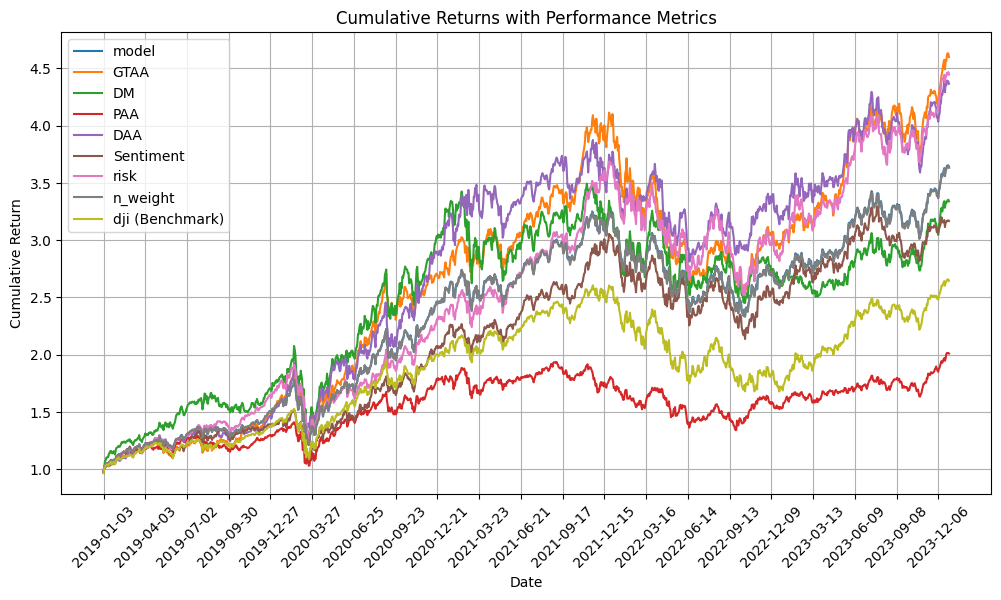

model Metrics:
  Information Ratio: 0.0463
  CVaR: -0.0385
  Rachev Ratio: 0.8824
GTAA Metrics:
  Information Ratio: 0.0666
  CVaR: -0.0427
  Rachev Ratio: 0.8916
DM Metrics:
  Information Ratio: 0.0247
  CVaR: -0.0489
  Rachev Ratio: 0.9380
PAA Metrics:
  Information Ratio: -0.0321
  CVaR: -0.0351
  Rachev Ratio: 0.8933
DAA Metrics:
  Information Ratio: 0.0375
  CVaR: -0.0399
  Rachev Ratio: 0.9582
Sentiment Metrics:
  Information Ratio: 0.0208
  CVaR: -0.0374
  Rachev Ratio: 0.9657
risk Metrics:
  Information Ratio: 0.0624
  CVaR: -0.0393
  Rachev Ratio: 0.9580
n_weight Metrics:
  Information Ratio: 0.0461
  CVaR: -0.0385
  Rachev Ratio: 0.8821
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/1y/1y_risk_scaled_data_actor_num_agent_4_lr0.0001_critic_lr1e-05_gamma0.99_eps_clip0.1_reward_cond_combined_entropy_weight0.1__k_epoch80_TARN_mappo_model.pth loaded.
Day: 2019-01-02 ~ 2019-01-30
[0.17701581 0.18508288 0.14442183 0.1571027  0.13268085 0.20369588]
{'GTAA': np.float32(0.16835052), '

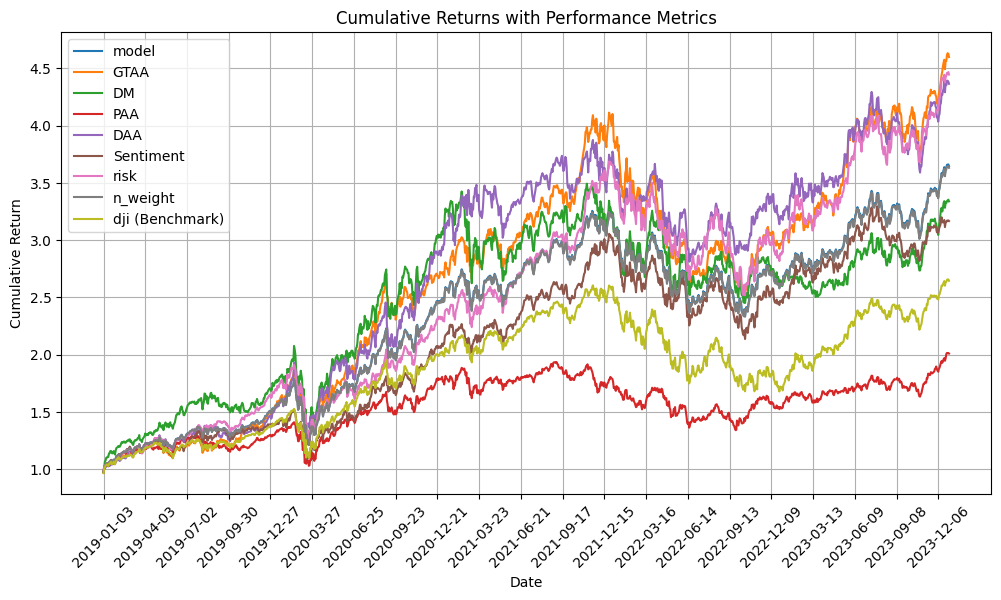

model Metrics:
  Information Ratio: 0.0468
  CVaR: -0.0386
  Rachev Ratio: 0.8823
GTAA Metrics:
  Information Ratio: 0.0666
  CVaR: -0.0427
  Rachev Ratio: 0.8916
DM Metrics:
  Information Ratio: 0.0247
  CVaR: -0.0489
  Rachev Ratio: 0.9380
PAA Metrics:
  Information Ratio: -0.0321
  CVaR: -0.0351
  Rachev Ratio: 0.8933
DAA Metrics:
  Information Ratio: 0.0375
  CVaR: -0.0399
  Rachev Ratio: 0.9582
Sentiment Metrics:
  Information Ratio: 0.0208
  CVaR: -0.0374
  Rachev Ratio: 0.9657
risk Metrics:
  Information Ratio: 0.0624
  CVaR: -0.0393
  Rachev Ratio: 0.9580
n_weight Metrics:
  Information Ratio: 0.0461
  CVaR: -0.0385
  Rachev Ratio: 0.8821
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/1y/1y_risk_scaled_data_actor_num_agent_4_lr0.0001_critic_lr1e-05_gamma0.99_eps_clip0.1_reward_cond_sharpe_entropy_weight0.1__k_epoch80_TARN_mappo_model.pth loaded.
Day: 2019-01-02 ~ 2019-01-30
[0.15058675 0.16695976 0.14015351 0.18654591 0.18568267 0.17007133]
{'GTAA': np.float32(0.16398452), 'DM

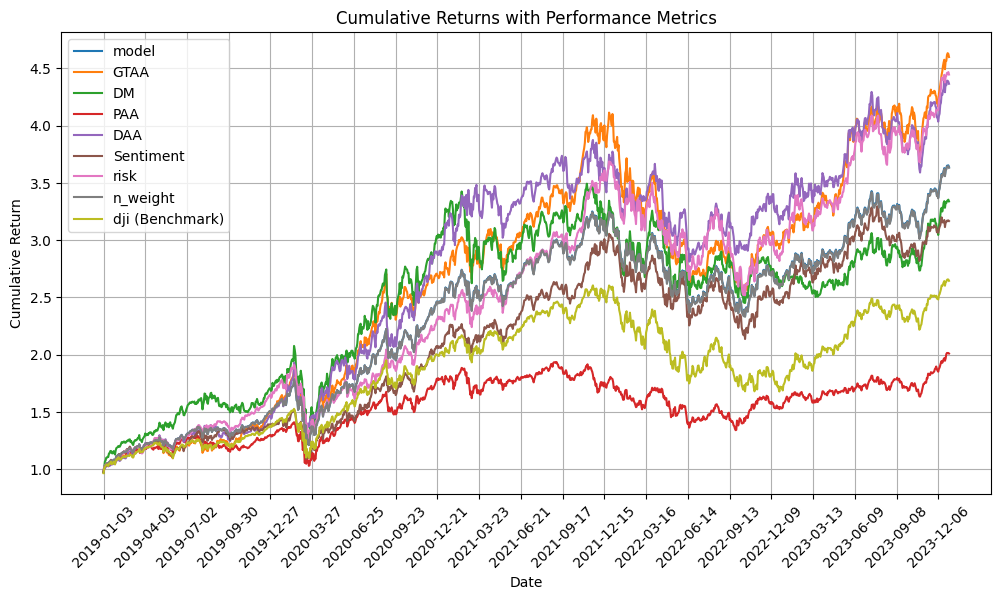

model Metrics:
  Information Ratio: 0.0463
  CVaR: -0.0385
  Rachev Ratio: 0.8824
GTAA Metrics:
  Information Ratio: 0.0666
  CVaR: -0.0427
  Rachev Ratio: 0.8916
DM Metrics:
  Information Ratio: 0.0247
  CVaR: -0.0489
  Rachev Ratio: 0.9380
PAA Metrics:
  Information Ratio: -0.0321
  CVaR: -0.0351
  Rachev Ratio: 0.8933
DAA Metrics:
  Information Ratio: 0.0375
  CVaR: -0.0399
  Rachev Ratio: 0.9582
Sentiment Metrics:
  Information Ratio: 0.0208
  CVaR: -0.0374
  Rachev Ratio: 0.9657
risk Metrics:
  Information Ratio: 0.0624
  CVaR: -0.0393
  Rachev Ratio: 0.9580
n_weight Metrics:
  Information Ratio: 0.0461
  CVaR: -0.0385
  Rachev Ratio: 0.8821
error
error
error


In [9]:
model_path = "../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/1y"
all_files_and_folders = os.listdir(model_path)
filtered_items = [item for item in all_files_and_folders if (item != 'old') & (item != 'episode_high')& (item != 'TD3')]
# config_ex = EnvConfig(test_scaled_tensor, test_dataset, test_data, hyperparameters)
# env_ex = Stock_Env(config_ex)
def set_seed(seed):
    # random.seed(seed)
    # np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)  # Multi-GPU 환경 고려
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {seed}")

SEED = 42
set_seed(SEED)


for model in filtered_items:

    config = EnvConfig(test_scaled_tensor, test_dataset, hyperparameters)
    env_test = Stock_Env(config, eval = True)
    config.save_path = model_path + "/" + model
    agent = PPO(config)
    try:
        agent.load()
        rewards, n_rewards, all_weight_invest_rewards, asset_weight_li, top3_action_li, attn_li, empty_df, all_weight_df, asset_weight_df = eval_env(env_test, agent)
        asset_weight_df.rename(columns={"invest": "n_weight"}, inplace=True)
        empty_df.rename(columns={"invest": "model"}, inplace=True)
        tot_data = pd.concat([empty_df, all_weight_df, asset_weight_df], axis=1)
        tot_data = pd.concat([tot_data, dji], axis=1)
        tot_data.to_csv("tot_data.csv")
        # Example Usage
        # Assuming `result` DataFrame is prepared with "PPO 25 epochs", "CPPO 25 epochs", and "Nasdaq-100 index"
        strategies = ['model', 'GTAA', 'DM', 'PAA', 'DAA', 'Sentiment', 'risk', 'n_weight']
        #strategies = ["PPO 20 epochs", "CPPO 20 epochs", "CPPO-DeepSeek 20 epochs"]
        benchmark = "dji"
        metrics = compute_metrics(tot_data, strategies, benchmark)
        plot_cumulative_returns(tot_data, metrics, strategies, benchmark)

        # Print metrics
        for strategy, strategy_metrics in metrics.items():
            print(f"{strategy} Metrics:")
            for metric_name, value in strategy_metrics.items():
                print(f"  {metric_name}: {value:.4f}")
    except:
        print("error")
        continue

Random seed set to: 42
error
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/1y/1y_risk_scaled_data_actor_num_agent_4_lr0.0001_critic_lr1e-05_gamma0.99_eps_clip0.1_reward_cond_combined_contest_entropy_weight0.1__k_epoch80_TARN_mappo_model.pth loaded.
Day: 2019-01-02 ~ 2019-01-30
Day: 2019-01-31 ~ 2019-02-28
Day: 2019-03-01 ~ 2019-03-28
Day: 2019-03-29 ~ 2019-04-26
Day: 2019-04-29 ~ 2019-05-24
Day: 2019-05-28 ~ 2019-06-24
Day: 2019-06-25 ~ 2019-07-23
Day: 2019-07-24 ~ 2019-08-20
Day: 2019-08-21 ~ 2019-09-18
Day: 2019-09-19 ~ 2019-10-16
Day: 2019-10-17 ~ 2019-11-13
Day: 2019-11-14 ~ 2019-12-12
Day: 2019-12-13 ~ 2020-01-13
Day: 2020-01-14 ~ 2020-02-11
Day: 2020-02-12 ~ 2020-03-11
Day: 2020-03-12 ~ 2020-04-08
Day: 2020-04-09 ~ 2020-05-07
Day: 2020-05-08 ~ 2020-06-05
Day: 2020-06-08 ~ 2020-07-06
Day: 2020-07-07 ~ 2020-08-03
Day: 2020-08-04 ~ 2020-08-31
Day: 2020-09-01 ~ 2020-09-29
Day: 2020-09-30 ~ 2020-10-27
Day: 2020-10-28 ~ 2020-11-24
Day: 2020-11-25 ~ 2020-12-23
Day: 2020-12-24 ~ 2021-0

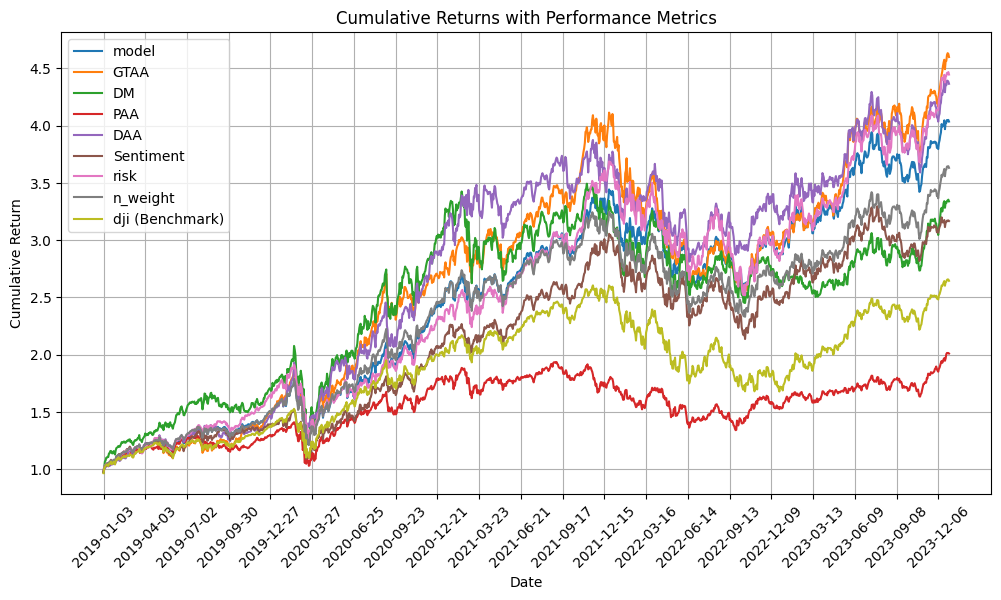

model Metrics:
  Information Ratio: 0.0523
  CVaR: -0.0373
  Rachev Ratio: 0.9042
GTAA Metrics:
  Information Ratio: 0.0666
  CVaR: -0.0427
  Rachev Ratio: 0.8916
DM Metrics:
  Information Ratio: 0.0247
  CVaR: -0.0489
  Rachev Ratio: 0.9380
PAA Metrics:
  Information Ratio: -0.0321
  CVaR: -0.0351
  Rachev Ratio: 0.8933
DAA Metrics:
  Information Ratio: 0.0375
  CVaR: -0.0399
  Rachev Ratio: 0.9582
Sentiment Metrics:
  Information Ratio: 0.0208
  CVaR: -0.0374
  Rachev Ratio: 0.9657
risk Metrics:
  Information Ratio: 0.0624
  CVaR: -0.0393
  Rachev Ratio: 0.9580
n_weight Metrics:
  Information Ratio: 0.0461
  CVaR: -0.0385
  Rachev Ratio: 0.8821
../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/1y/1y_risk_scaled_data_actor_num_agent_4_lr0.0001_critic_lr1e-05_gamma0.99_eps_clip0.1_reward_cond_combined_entropy_weight0.1__k_epoch80_TARN_mappo_model.pth loaded.
Day: 2019-01-02 ~ 2019-01-30
Day: 2019-01-31 ~ 2019-02-28
Day: 2019-03-01 ~ 2019-03-28
Day: 2019-03-29 ~ 2019-04-26
Day: 2019-04-29

In [ ]:
model_path = "../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/1y"
all_files_and_folders = os.listdir(model_path)
filtered_items = [item for item in all_files_and_folders if (item != 'old') & (item != 'episode_high')& (item != 'TD3')]
# config_ex = EnvConfig(test_scaled_tensor, test_dataset, test_data, hyperparameters)
# env_ex = Stock_Env(config_ex)
def set_seed(seed):
    # random.seed(seed)
    # np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)  # Multi-GPU 환경 고려
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {seed}")

SEED = 42
set_seed(SEED)


for model in filtered_items:

    config = EnvConfig(test_scaled_tensor, test_dataset, hyperparameters)
    env_test = Stock_Env(config, eval = True)
    config.save_path = model_path + "/" + model
    agent = PPO(config)
    try:
        agent.load()
        rewards, n_rewards, all_weight_invest_rewards, asset_weight_li, top3_action_li, attn_li, empty_df, all_weight_df, asset_weight_df = eval_env(env_test, agent)
        asset_weight_df.rename(columns={"invest": "n_weight"}, inplace=True)
        empty_df.rename(columns={"invest": "model"}, inplace=True)
        tot_data = pd.concat([empty_df, all_weight_df, asset_weight_df], axis=1)
        tot_data = pd.concat([tot_data, dji], axis=1)
        tot_data.to_csv("tot_data.csv")
        # Example Usage
        # Assuming `result` DataFrame is prepared with "PPO 25 epochs", "CPPO 25 epochs", and "Nasdaq-100 index"
        strategies = ['model', 'GTAA', 'DM', 'PAA', 'DAA', 'Sentiment', 'risk', 'n_weight']
        #strategies = ["PPO 20 epochs", "CPPO 20 epochs", "CPPO-DeepSeek 20 epochs"]
        benchmark = "dji"
        metrics = compute_metrics(tot_data, strategies, benchmark)
        plot_cumulative_returns(tot_data, metrics, strategies, benchmark)

        # Print metrics
        for strategy, strategy_metrics in metrics.items():
            print(f"{strategy} Metrics:")
            for metric_name, value in strategy_metrics.items():
                print(f"  {metric_name}: {value:.4f}")
    except:
        print("error")
        continue

In [17]:
model_path = "../Task_1_FinRL_DeepSeek_Stock/TARN_MAPPO/model/3m"
all_files_and_folders = os.listdir(model_path)
filtered_items = [item for item in all_files_and_folders if (item != 'old') & (item != 'episode_high')& (item != 'TD3')]
# config_ex = EnvConfig(test_scaled_tensor, test_dataset, test_data, hyperparameters)
# env_ex = Stock_Env(config_ex)
# set_seed(SEED)



for model in filtered_items:

    config = EnvConfig(test_scaled_tensor, test_dataset, hyperparameters)
    env_test = Stock_Env(config)
    config.save_path = model_path + "/" + model
    print(model)
    agent = PPO(config)
    agent.load()
    rewards, n_rewards, all_weight_invest_rewards, asset_weight_li, top3_action_li, attn_li, empty_df, all_weight_df, asset_weight_df = eval_env(env_test, agent)
    asset_weight_df.rename(columns={"invest": "n_weight"}, inplace=True)
    empty_df.rename(columns={"invest": "model"}, inplace=True)
    tot_data = pd.concat([empty_df, all_weight_df, asset_weight_df], axis=1)
    tot_data = pd.concat([tot_data, dji], axis=1)
    tot_data.to_csv("tot_data.csv")
    # Example Usage
    # Assuming `result` DataFrame is prepared with "PPO 25 epochs", "CPPO 25 epochs", and "Nasdaq-100 index"
    strategies = ['model', 'GTAA', 'DM', 'PAA', 'DAA', 'Sentiment', 'risk', 'n_weight']
    #strategies = ["PPO 20 epochs", "CPPO 20 epochs", "CPPO-DeepSeek 20 epochs"]
    benchmark = "dji"
    metrics = compute_metrics(tot_data, strategies, benchmark)
    plot_cumulative_returns(tot_data, metrics, strategies, benchmark)

    # Print metrics
    for strategy, strategy_metrics in metrics.items():
        print(f"{strategy} Metrics:")
        for metric_name, value in strategy_metrics.items():
            print(f"  {metric_name}: {value:.4f}")

AttributeError: 'Stock_Env' object has no attribute 'days'

In [59]:
tot_data.columns

Index(['model', 'GTAA', 'DM', 'PAA', 'DAA', 'Sentiment', 'risk', 'n_weight',
       'dji'],
      dtype='object')

In [ ]:
strategies = [
"PPO 100 epochs",
"CPPO 100 epochs",
"PPO-DeepSeek 100 epochs",
#"PPO-Llama 100 epochs",
"CPPO-DeepSeek 100 epochs"
#"CPPO-Llama 100 epochs",
]
#strategies = ["PPO 20 epochs", "CPPO 20 epochs", "CPPO-DeepSeek 20 epochs"]
benchmark = "Nasdaq-100 index"
metrics = compute_metrics(result, strategies, benchmark)
plot_cumulative_returns(result, metrics, strategies, benchmark)

# Print metrics
for strategy, strategy_metrics in metrics.items():
    print(f"{strategy} Metrics:")
    for metric_name, value in strategy_metrics.items():
        print(f"  {metric_name}: {value:.4f}")

,model,GTAA,DM,PAA,DAA,Sentiment,risk,n_weight,dji
date,,,,,,,,,
2019-01-02,9.990999e+06,9.990000e+06,9.990000e+06,9.990000e+06,9.993000e+06,9.990000e+06,9.990001e+06,9.990502e+06,1.000000e+06
2019-01-03,9.704073e+06,9.705997e+06,9.512801e+06,9.769256e+06,9.830203e+06,9.736343e+06,9.795943e+06,9.725087e+06,9.663976e+05
2019-01-04,1.040817e+07,1.027454e+07,1.056626e+07,1.046154e+07,1.019665e+07,1.039467e+07,1.034109e+07,1.037247e+07,1.009716e+06
2019-01-07,1.026746e+07,1.025094e+07,1.032915e+07,1.040040e+07,1.007278e+07,1.013538e+07,1.007024e+07,1.020982e+07,1.020026e+06
2019-01-08,1.001184e+07,1.003445e+07,9.988437e+06,1.004238e+07,1.000470e+07,1.008312e+07,1.009856e+07,1.004194e+07,1.030024e+06
...,...,...,...,...,...,...,...,...,...
2023-12-22,1.069291e+07,1.225094e+07,1.086144e+07,1.090780e+07,1.027825e+07,1.060461e+07,9.778445e+06,1.087576e+07,2.637595e+06
2023-12-26,1.081676e+07,1.238092e+07,1.098421e+07,1.104513e+07,1.039705e+07,1.065504e+07,9.770315e+06,1.096613e+07,2.653483e+06
2023-12-27,1.075536e+07,1.228606e+07,1.093828e+07,1.099517e+07,1.034680e+07,1.057060e+07,9.744418e+06,1.090801e+07,2.657938e+06


In [ ]:
def make_cummlative_return(empty_df, data, col):
    empty_df[f"{col}"]= (1+ data[col]).cumprod()-1
    return empty_df

def visualize_data(save_cum, item):
    # 누적 수익률 그래프

    
    plt.figure(figsize=(12, 8))

    unique_colors = [
        "blue", "cyan", "orange", "green", "red", "purple", "brown", 
        "pink", "gray", "olive", "magenta", "yellow", "black"
    ]    
    for i,  category in enumerate(save_cum.columns):
        if category == "TARN_PPO":
            plt.plot(save_cum.index, save_cum[category], label=category, color=unique_colors[i], marker="o", markersize=5)
        elif category == "n_weight":
            plt.plot(save_cum.index, save_cum[category], label=category, color=unique_colors[i], marker="s", markersize=5)
        elif category == "Dow Jones Index":
            plt.plot(save_cum.index, save_cum[category], label=category, color=unique_colors[i], marker="o", markersize=5)
        else:
            plt.plot(save_cum.index, save_cum[category], label=category, color=unique_colors[i])
        # 그래프 설정
        plt.title('Cumulative Returns Over Time', fontsize=20)
        plt.xlabel('Date', fontsize=15)
        plt.ylabel('Cumulative Return', fontsize=15)
        plt.legend(fontsize=10, loc='upper left')  # 범례를 왼쪽 위로 이동
        plt.grid(alpha=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()


    # 그래프 출력
    plt.show()
    plt.savefig(f"./TARN_MAPPO/fig/{item}.png")

In [1]:
empty_df, asset_weight_df

NameError: name 'empty_df' is not defined

In [10]:
config = EnvConfig(test_scaled_tensor, test_dataset, test_data, hyperparameters)
env_test = Stock_Env(config)

In [21]:
config.save_path = model_path + "/" + filtered_items[0]
agent = PPO(config)
agent.load()

./TARN_MAPPO/model/scaled_data_actor_num_agent_2_lr0.001_critic_lr0.001_gamma0.99_eps_clip0.1_reward_cond_combined_entropy_weight0.5_TARN_mappo_model.pth loaded.


In [22]:
rewards, n_rewards, all_weight_invest_rewards = eval_env(env_test, agent)

AttributeError: 'Stock_Env' object has no attribute 'window_states'

In [ ]:




test_scaled_data_path = "data/test_small_var_data.pkl"
test_dataset_path = "data/test_data.csv"
test_scaled_tensor_path = "data/test_small_var_episodes.pt"
with open(test_scaled_data_path, "rb") as f:
    test_data = pickle.load(f)
    
test_dataset = pd.read_csv(test_dataset_path, index_col=0)

test_scaled_tensor = torch.load(test_scaled_tensor_path)
keys_list = list(test_data.keys())[:45]
slice_data = {key: test_data[key] for key in keys_list}
test_data = {0: slice_data}
test_dataset = test_dataset.loc[keys_list]
test_scaled_tensor["0"] = test_scaled_tensor["0"][:45]
# feature_dim = 35
feature_dim = 20

# # --- Hyperparameters ---
# def get_hyperparameters(feature_dim):
#     return {
#         "dcc_dropout": 0.2,
#         "sac_dropout": 0.01,
#         "sac_heads": 2,
#         "ddc_configs": [
#             {"in_channels": feature_dim, "out_channels": 8, "kernel_size": 3, "stride": 1, "padding": (3-1)//2, "dilation": 1, "sac_scale": 4**0.5, "residual_out_channels" : 8, "residual_kernal": 1},
#             {"in_channels": 8, "out_channels": 16, "kernel_size": 3, "stride": 1, "padding": 2, "dilation": 2, "sac_scale": 8**0.5, "residual_out_channels" : 16, "residual_kernal": 1 },
#             {"in_channels": 16, "out_channels": 16, "kernel_size": 3, "stride": 1, "padding": 4, "dilation": 4, "sac_scale": 8**0.5}
#         ],
#         "final_conv_config": {"in_channels" : 16, "out_channels": 16, "kernel_size": 31, "stride": 1, "padding": 0}
#     }
    
def get_hyperparameters(feature_dim):
    return {
        "dcc_dropout": 0.2,
        "sac_dropout": 0.01,
        "sac_heads": 2,
        "ddc_configs": [
            {"in_channels": feature_dim, "out_channels": 8, "kernel_size": 3, "stride": 1, "padding": (3-1)//2, "dilation": 1, "sac_scale": 4**0.5, "residual_out_channels" : 8, "residual_kernal": 1},
            {"in_channels": 8, "out_channels": 16, "kernel_size": 3, "stride": 1, "padding": 2, "dilation": 2, "sac_scale": 8**0.5, "residual_out_channels" : 16, "residual_kernal": 1 },
            {"in_channels": 16, "out_channels": 16, "kernel_size": 3, "stride": 1, "padding": 4, "dilation": 4, "sac_scale": 8**0.5}
        ],
        "final_conv_config": {"in_channels" : 8, "out_channels": 8, "kernel_size": 31, "stride": 1, "padding": 0}
    }




hyperparameters = get_hyperparameters(feature_dim)

save_eval = {}
model_path = "./TARN_MAPPO/model/small_var_model"
model_name = "scaled_data_patience_10update_interval_5_action_std_init_0.5_actor_lr0.0001_critic_lr0.01_gamma0.9_numagent_2_update5_eps_clip0.1_ppo_model_.pth"